<a href="https://colab.research.google.com/github/lala991204/DL-self-study/blob/master/tensorflow/4_6_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

이미지 분할(Segmentation)은 모든 픽셀에 대한 정답 클래스를 가지고, 딥러닝 모델을 훈련시켜 배경,객체를 분리하는 방식임. \
같은 범주의 여러 객체를 하나의 범주로 묶어 구분하는 의미 분할(semantic segmentation)과 같은 범주에 속하더라도 서로 다른 객체를 구분하는 인스턴스 분할(instance segmentation)로 나눔.

마스크: 각 픽셀에 대한 범주 레이블(대상이 속한, 인접한, 속하지 않는 주변 픽셀 3가지)

In [ ]:
# (모델 학습에 필요한 input)image의 크기
img_w = 128
img_h = 128
img_c = 3
img_shape = (img_w, img_h, img_c)

# model learning
epoch_num = 5
learning_rate = 0.0001
buffer_size = 1000
batch_size = 16

# tensorflow dataset load
ds_str = 'oxford_iiit_pet'
ds, info = tfds.load(name=ds_str, with_info=True)

In [ ]:
# image 전처리 함수
def preprocess_image(ds):
    # 원본 image
    img = tf.image.resize(ds['image'], (img_w, img_h))
    img = tf.cast(img, tf.float32) / 255.0        # 자료형 변환, 0~1 범위로 정규화
    # 분할 마스크
    mask = tf.image.resize(ds['segmentation_mask'], (img_w, img_h))
    mask = tf.cast(mask, tf.int32)
    mask = mask - 1          # 0,1,2의 정수형 값을 가지도록.
    return img, mask

# 데이터 전처리 파이프라인(미니배치로 분할까지!)
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
print(train_ds)

img, mask = next(iter(train_ds))
print(len(img))             # 하나의 배치에 16개의 샘플 이미지, 마스크 이미지

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>
16


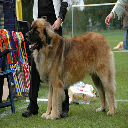

In [ ]:
# sample image 출력
img = np.array(img[0]) * 255.0       # 정규화 이전 값으로 복원
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

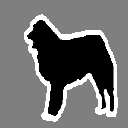

In [ ]:
# sample mask 출력
mask = (np.array(mask[0])/2) * 255.0    # 마스크 범위는 0~2이므로 2로 나눔 => 복원(RGB image로 표현가능.)
cv2_imshow(mask)

In [ ]:
# VGG16 model(사전학습된)
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


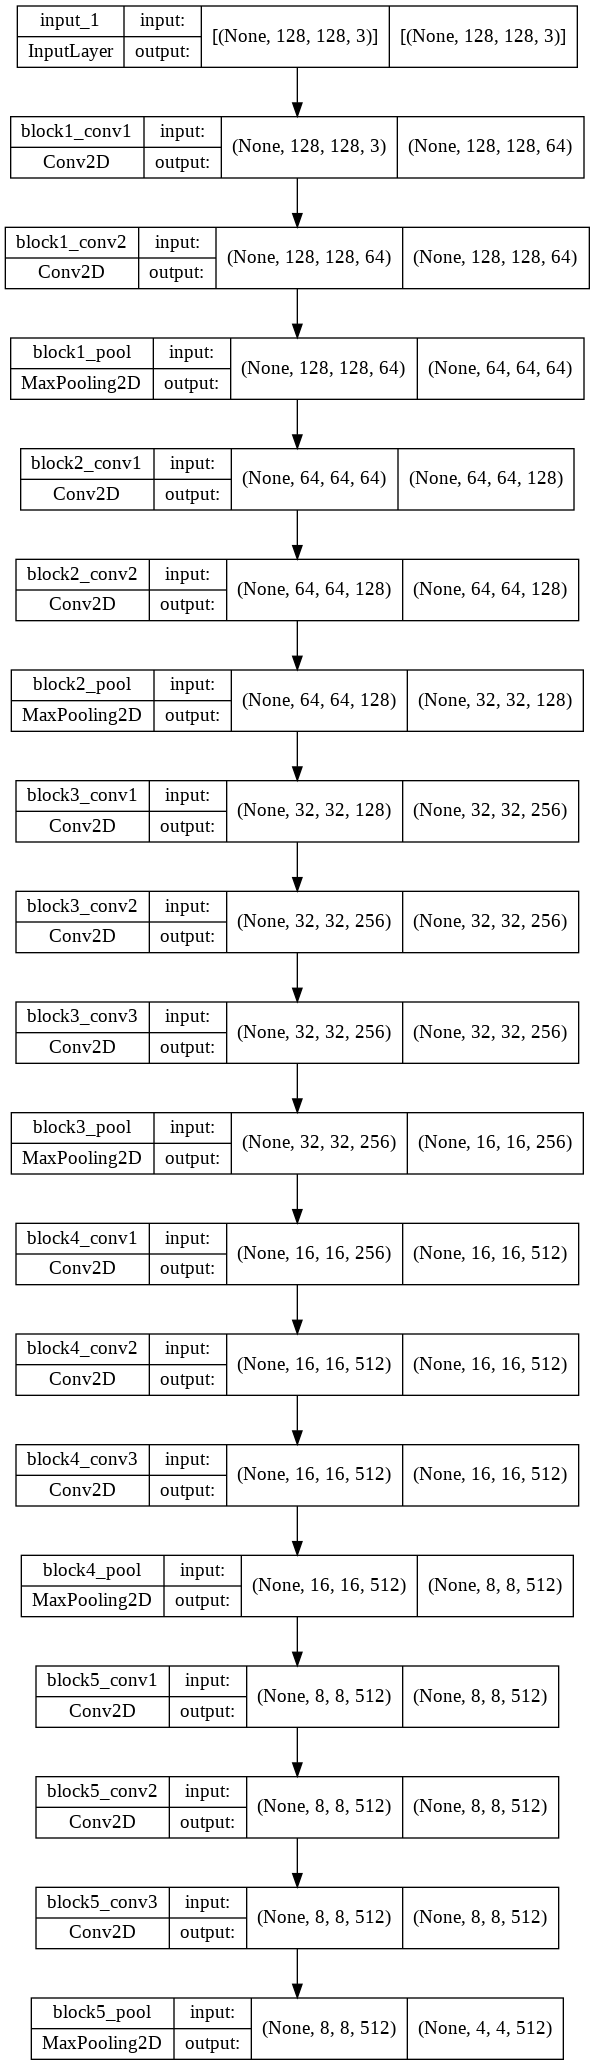

In [ ]:
# model 구조
tf.keras.utils.plot_model(base_model, show_shapes=True)

사전 학습된 VGG16 model을 incoder로 활용하는 U-Net model을 만들어보자.

In [ ]:
# VGG16 중간 layer 출력 텐서 지정
f_model = tf.keras.Model(inputs=[base_model.input],
                         outputs=[
                                  base_model.get_layer(name='block5_conv3').output,
                                  base_model.get_layer(name='block4_conv3').output,
                                  base_model.get_layer(name='block3_conv3').output,
                                  base_model.get_layer(name='block2_conv2').output,
                                  base_model.get_layer(name='block1_conv2').output
                         ])

# 파라미터 고정(<=사전 학습된 파람미터를 인코더에 그대로 사용하기 위해 업데이트되지 않도록 고정)
f_model.trainable = False

## U-Net 구조(인코더-디코더)로 모델 정의
i = tf.keras.Input(shape=img_shape)

# 인코더 부분에서 5개의 출력을 가져와 디코더의 입력으로 전달=> 업샘플링
# 업샘플링: 축소된 이미지를 원래 이미지 크기로 복원하는 과정.
out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, \       
out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out, out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_128_128_64])

out = tf.keras.layers.Conv2D(3, 3, activation='elu', padding='same')(out)
out = tf.keras.layers.Dense(3, activation='softmax')(out)

unet_model = tf.keras.Model(inputs=[i], outputs=[out])

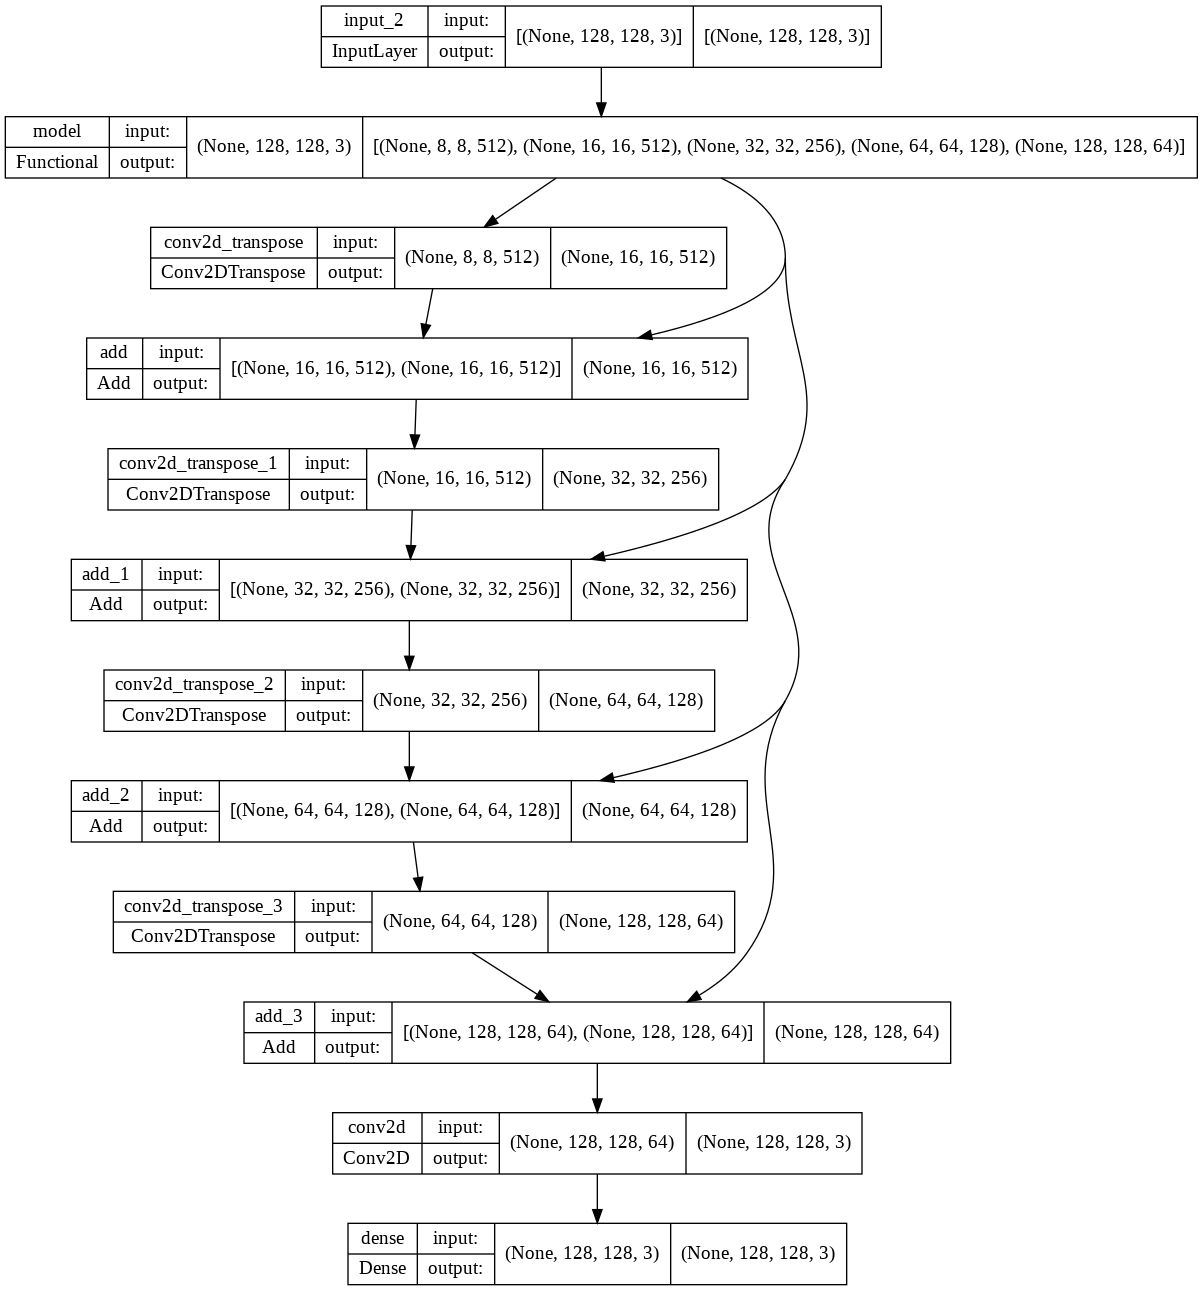

In [ ]:
# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [ ]:
# 모델 요약
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 8, 8, 512),  14714688    ['input_2[0][0]']                
                                 (None, 16, 16, 512                                               
                                ),                                                                
                                 (None, 32, 32, 256                                               
                                ),                                                          

In [ ]:
loss_f = tf.losses.SparseCategoricalCrossentropy()
opt = tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])
unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/5
230/230 [==============================] - 1320s 6s/step - loss: 0.9686 - accuracy: 0.5849
Epoch 2/5
230/230 [==============================] - 1283s 6s/step - loss: 0.8943 - accuracy: 0.6018
Epoch 3/5
230/230 [==============================] - 1279s 6s/step - loss: 0.8320 - accuracy: 0.6469
Epoch 4/5
230/230 [==============================] - 1280s 6s/step - loss: 0.6553 - accuracy: 0.7903
Epoch 5/5
230/230 [==============================] - 1279s 6s/step - loss: 0.5611 - accuracy: 0.8374


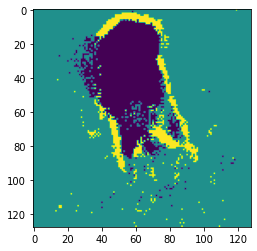

In [ ]:
# 1개 배치(16개 이미지)를 선택
img, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(img)

# 첫 번째 이미지 분할 결과를 출력
pred_img = np.argmax(pred[0], -1)
plt.imshow(pred_img)

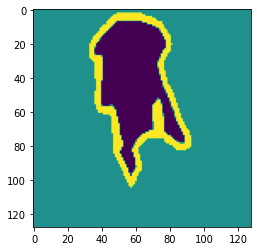

In [ ]:
# 첫 번째 이미지의 정답 마스크 출력
plt.imshow(np.reshape(mask[0], (128, 128)))